# INGV - Volcanic Eruption Prediction
## NWI-IBI008: Data Mining
### Authors: 
Steffen de Jong (S1065975)<br>
Sebastiaan Ram (S1063000)

In [45]:
# Initial imports
import pandas as pd
import numpy as np
import os, os.path
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
import pywt
from IPython.display import clear_output
sns.set_theme()

pd.__version__

fig_nr = 1
generate_train_set = False
generate_test_set = False

In [2]:
def clean_df(df):
    cols = list(df.filter(regex='sum|kurtosis'))

    df[cols] = df[cols].replace({0:np.nan})

    df.drop([col for col in df.columns if 'sum' in col and 'pc' in col],axis=1,inplace=True)

    df = df[df.columns.drop(list(df.filter(regex='percentile_50')))]

    df = df.merge(train, how='left', on='segment_id').set_index('segment_id')

    df = df.sort_values(by=['sensor_1_mean'])
    df = df.fillna(method='bfill')
    df = df.fillna(method='ffill')
    
    return df

In [47]:
def random_forest_generator(max_depth, X, y, fig_description, fig_title):
    mean_r2_sc = np.array([])
    mean_mae_score = np.array([])

    best_r2 = {"var": 0, "val":-np.inf}
    best_mae = {"var": 0, "val":np.inf}

    kf = KFold(n_splits=10, random_state=42, shuffle=True)

    for i in max_depth:
        rfr = RandomForestRegressor(max_depth=i, verbose=1, n_jobs=-1)

        r2_sc = np.array([])
        mae_score = np.array([])

        r2_sc_nor = np.array([])
        mae_score_nor = np.array([])

        for train_index, test_index in kf.split(X):        
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = rfr.fit(X_train, y_train)

            pred = rfr.predict(X_test)

            r2_sc = np.append(r2_sc, r2_score(y_test, pred))
            mae_score = np.append(mae_score, mean_absolute_error(y_test, pred))

        if r2_sc.mean() > best_r2['val']: 
            best_r2['var'] = i
            best_r2['val'] = r2_sc.mean()
        if mae_score.mean() < best_mae['val']: 
            best_mae['var'] = i
            best_mae['val'] = mae_score.mean()

        mean_r2_sc = np.append(mean_r2_sc, r2_sc.mean())
        mean_mae_score = np.append(mean_mae_score, mae_score.mean())

        clear_output(wait=True)
        print("Tree depth: {}".format(i))

    fig, axes = plt.subplots(1,2,figsize=(15,7), sharex=True)

    sns.lineplot(x=max_depth, y=mean_r2_sc, data=mean_r2_sc, ax=axes[0])
    sns.lineplot(x=max_depth, y=mean_mae_score, data=mean_mae_score, ax=axes[1])

    axes[0].set_xlabel("Max depth")
    axes[0].set_ylabel("R2 score")
    
    axes[1].set_xlabel("Max depth")
    axes[1].set_ylabel("Mean absolute error")

    plt.figtext(0.5,0.07,fig_description, fontsize=11, horizontalalignment="center")
    plt.title(fig_title)
    
    plt.savefig("rf", bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()
    
    return best_r2, best_mae

In [4]:
def knn_generator(rng, X, y, fig_description, fig_title):
    mean_r2_sc = np.array([])
    mean_mae_score = np.array([])

    best_r2 = {"var": 0, "val":-np.inf}
    best_mae = {"var": 0, "val":np.inf}

    kf = KFold(n_splits=10, random_state=42, shuffle=True)

    neighbor_count = 1

    for i in rng:
        neigh = KNeighborsRegressor(n_neighbors=i, n_jobs=-1)

        r2_sc = np.array([])
        mae_score = np.array([])

        for train_index, test_index in kf.split(X):        
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = neigh.fit(X_train, y_train)

            pred = model.predict(X_test)

            r2_sc = np.append(r2_sc, r2_score(y_test, pred))
            mae_score = np.append(mae_score, mean_absolute_error(y_test, pred))

        if r2_sc.mean() > best_r2['val']: 
            best_r2['var'] = i
            best_r2['val'] = r2_sc.mean()
        if mae_score.mean() < best_mae['val']: 
            best_mae['var'] = i
            best_mae['val'] = mae_score.mean()

        mean_r2_sc = np.append(mean_r2_sc, r2_sc.mean())
        mean_mae_score = np.append(mean_mae_score, mae_score.mean())

        clear_output(wait=True)
        print("Neighbors trained: {}".format(neighbor_count))
        neighbor_count = neighbor_count + 1

    fig, axes = plt.subplots(1,2,figsize=(15,7), sharex=True)

    sns.lineplot(x=rng, y=mean_r2_sc, data=mean_r2_sc, ax=axes[0])
    sns.lineplot(x=rng, y=mean_mae_score, data=mean_mae_score, ax=axes[1])
    
    axes[0].set_xlabel("Number of neighbors")
    axes[0].set_ylabel("R2 score")
    
    axes[1].set_xlabel("Number of neighbors")
    axes[1].set_ylabel("Mean absolute error")

    plt.figtext(0.5,0.07,fig_description, fontsize=11, horizontalalignment="center")
    plt.title(fig_title)
    
    plt.savefig("knn", bbox_inches = 'tight', pad_inches = 0)
    
    plt.show()

    return best_r2, best_mae

In [5]:
def linear_regression_generator(X, y):
    kf = KFold(n_splits=5, random_state=42, shuffle=True)

    lr = LinearRegression(n_jobs=-1)

    r2_sc = np.array([])
    mae_score = np.array([])

    r2_sc_nor = np.array([])
    mae_score_nor = np.array([])

    for train_index, test_index in kf.split(X):        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = lr.fit(X_train, y_train)

        pred = model.predict(X_test)

        r2_sc = np.append(r2_sc, r2_score(y_test, pred))
        mae_score = np.append(mae_score, mean_absolute_error(y_test, pred))
        
    return r2_sc, mae_score 

In [6]:
# Laod both the train data and the sample_submissions csv in pandas dataframes
train = pd.read_csv("data/train.csv")
submission = pd.read_csv("data/sample_submission.csv")

#### Features

From https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe/data:

**train_csv**:
- `segment_id` ID code for the data segment. Matches the name of the associated data file.
- `time_to_eruption` The target value, the time until the next eruption (metric unknown).

For **[train|test]/\*.csv**`:<br>
The data files. Each file contains ten minutes of logs from ten different sensors arrayed around a volcano. The readings have been normalized within each segment, in part to ensure that the readings fall within the range of int16 values. If you are using the Pandas library you may find that you still need to load the data as float32 due to the presence of some nulls.

### Train.csv

The `train.csv` file contains the segment id and the tte (time to eruption). We are able to link each segment id to a segment contained in the `test/` and `train/` folders.

In [7]:
# Let's first inspect our data
train.head()

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429


In [8]:
train.describe()

,segment_id,time_to_eruption
count,4.431000e+03,4.431000e+03
mean,1.074694e+09,2.284891e+07
std,6.161966e+08,1.348439e+07
min,5.131810e+05,6.250000e+03
25%,5.527934e+08,1.127016e+07
50%,1.066153e+09,2.246559e+07
75%,1.606350e+09,3.434356e+07
max,2.146939e+09,4.904609e+07


#### Findings
- The min TTE is 625
- The max TTE is somewhere $>$ 49.000.000
- The mean TTE is in the 10-millions and the 25th percentile is in the 1-million range, indicating that a lot of the TTE's are within the 10 million -> 40 million range.

In [9]:
# Confirm that we have as many rows in the train.csv file as that we have files in the train.csv folder?
DIR = 'data/test/'

print("Data in train.csv file: {}".format(train['segment_id'].nunique()))
print("Data in train folders: {}".format(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])))

Data in train.csv file: 4431
Data in train folders: 4520


It seems that we are missing around 100 segments in the train.csv file, we do not know where these segments are so we will have to eventually exclude them from the final prediction. 

In [10]:
# Check for any missing values
train.isnull().sum()

segment_id          0
time_to_eruption    0
dtype: int64

### Segment data


In [11]:
segment_id = 1000015382
segment = pd.read_csv("data/train/"+str(segment_id)+".csv")

In [12]:
segment.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,260.0,64.0,-232.0,-36.0,-2.0,-35.0,103.0,389.0,67.0,41.0
1,233.0,175.0,146.0,160.0,-4.0,29.0,-120.0,498.0,59.0,63.0
2,216.0,236.0,321.0,202.0,2.0,113.0,-230.0,554.0,97.0,90.0
3,156.0,205.0,382.0,6.0,12.0,70.0,-228.0,580.0,141.0,122.0
4,158.0,101.0,272.0,-154.0,16.0,45.0,-162.0,624.0,145.0,154.0


In [13]:
# Get dimensions of segment dataframe
segment.shape

(60001, 10)

In [14]:
segment.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
count,60001.000000,59847.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000
mean,0.382244,2.266563,2.192213,-0.148031,-0.263129,1.630089,-0.615190,-0.177964,-0.402777,0.896752
std,111.553322,451.741111,373.923764,231.812464,129.504432,222.294642,269.678045,319.999406,176.087814,249.024286
min,-920.000000,-7871.000000,-2444.000000,-1815.000000,-2484.000000,-1128.000000,-1453.000000,-2947.000000,-1585.000000,-2961.000000
25%,-66.000000,-163.000000,-223.000000,-150.000000,-30.000000,-147.000000,-172.000000,-194.000000,-106.000000,-117.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,67.000000,168.000000,224.000000,149.000000,30.000000,149.000000,174.000000,195.000000,106.000000,119.000000
max,822.000000,7321.000000,2563.000000,1491.000000,2608.000000,1119.000000,1668.000000,3676.000000,1162.000000,3179.000000


In [15]:
# Check for any missing values
segment.isna().sum()

sensor_1       0
sensor_2     154
sensor_3       0
sensor_4       0
sensor_5       0
sensor_6       0
sensor_7       0
sensor_8       0
sensor_9       0
sensor_10      0
dtype: int64

In [16]:
columns = segment.columns

columns

Index(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10'],
      dtype='object')

No handles with labels found to put in legend.


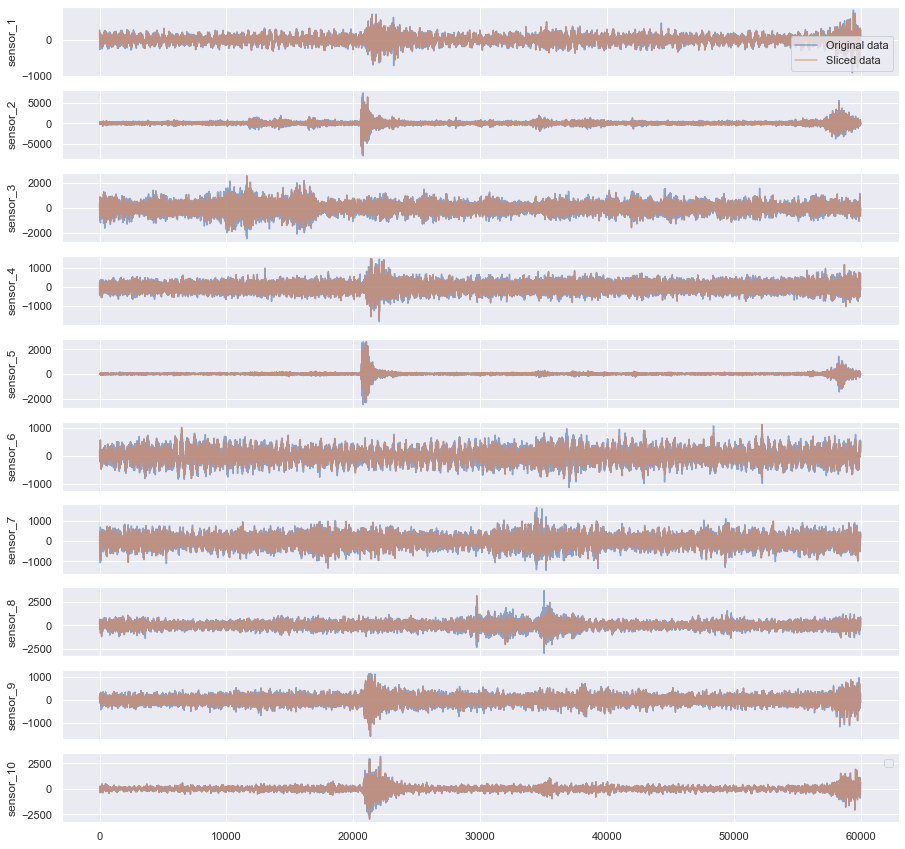

In [17]:
fig, axes = plt.subplots(len(segment.columns),figsize=(15,15), sharex=True)

short_segment = segment.iloc[::6]

for i, column in enumerate(segment.columns):
    if i==0: label, short_label = "Original data", "Sliced data"
    else: label, short_label = None, None
    
    sns.lineplot(data=segment[column], ax=axes[i], label=label, alpha=0.6)
    sns.lineplot(data=short_segment[column], ax=axes[i], label=short_label, alpha=0.6)

#plt.figtext(0.5,0.01,'Figure {}: '.format(fig_nr), fontsize=11, horizontalalignment="center")
plt.legend()
plt.savefig("seismoplot", bbox_inches = 'tight', pad_inches = 0)
plt.show()

fig_nr = fig_nr + 1

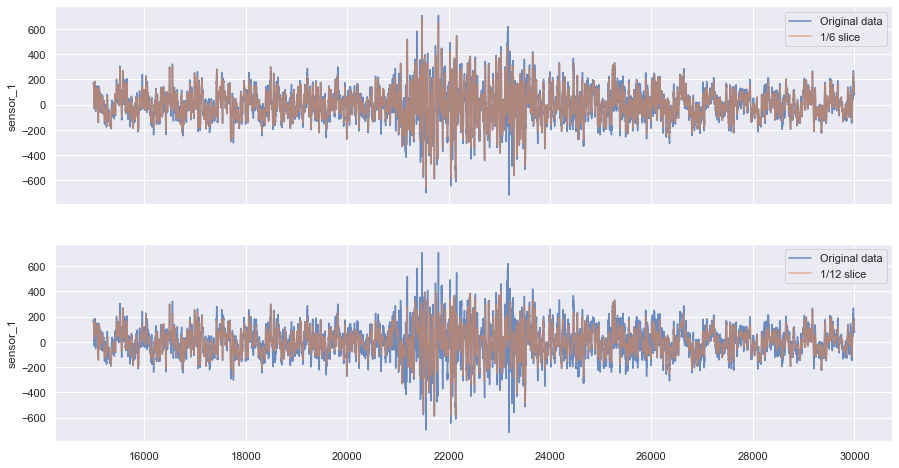

In [18]:
shorter_segment = segment.iloc[::12]
    
fig, axes = plt.subplots(nrows=2,figsize=(15,8), sharex=True)

sns.lineplot(data=segment['sensor_1'].loc[15000:30000], ax=axes[0], label="Original data", alpha=0.8)
sns.lineplot(data=short_segment['sensor_1'].loc[15000:30000], ax=axes[0], label="1/6 slice", alpha=0.6)

sns.lineplot(data=segment['sensor_1'].loc[15000:30000], ax=axes[1], label="Original data", alpha=0.8)
sns.lineplot(data=shorter_segment['sensor_1'].loc[15000:30000], ax=axes[1], label="1/12 slice", alpha=0.6)

#plt.figtext(0.5,0.01,'Figure {}: '.format(fig_nr), fontsize=11, horizontalalignment="center")
plt.savefig("seismoplot", bbox_inches = 'tight', pad_inches = 0)
plt.show()

fig_nr = fig_nr + 1

10010


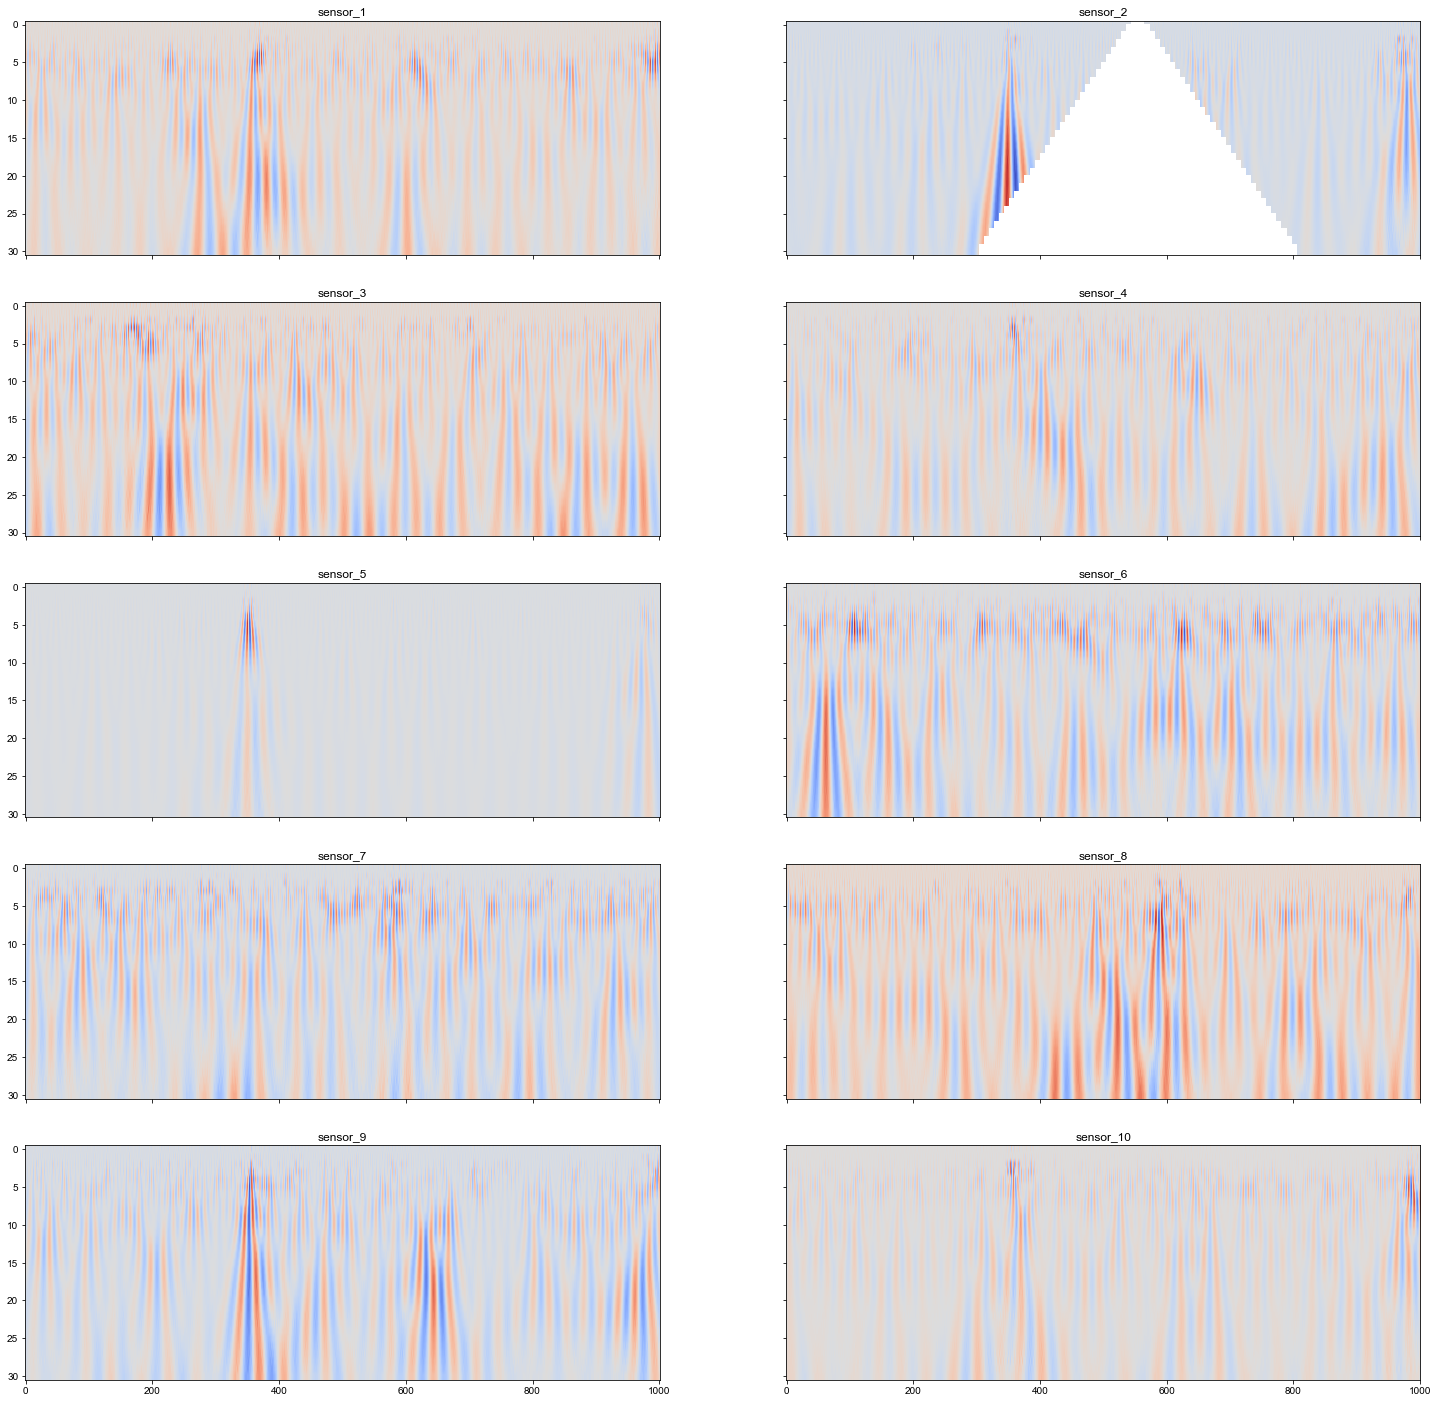

In [35]:
sns.reset_orig()

short_segment= segment.iloc[::60].reset_index(drop=True)
sensor_1 = segment["sensor_1"].values
scales = np.arange(1, 32)

fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(25,25))

for ax, column in zip(axs.flat, segment):
    coeffs, freqs = pywt.cwt(short_segment[column].values , scales, 'morl')
#     print(coeffs)
    ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
    ax.set_title(column)

print(short_segment.size)
coeffs.shape

sns.set_theme()

### File extraction

In [19]:
from toolbox.generate_dataset import *

if(generate_train_set): generate_aggregation("*", "data/train", "aggregated_train")
    
if(generate_test_set): generate_aggregation("*", "data/test", "aggregated_test")

### Using aggregated data

In [20]:
df = pd.read_csv("aggregated_train.csv")

df.head()

,sensor_1_kurtosis,sensor_10_kurtosis,sensor_2_kurtosis,sensor_3_kurtosis,sensor_4_kurtosis,sensor_5_kurtosis,sensor_6_kurtosis,sensor_7_kurtosis,sensor_8_kurtosis,sensor_9_kurtosis,...,sensor_10_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,segment_id
0,2.873691,14.978789,35.123455,1.653106,1.425662,110.539572,0.186371,0.503200,2.805086,2.838816,...,53806.0,135647.0,131535.0,-8882.0,-15788.0,97807.0,-36912.0,-10678.0,-24167.0,1000015382
1,0.154876,0.160791,0.735062,0.253124,0.358472,0.686427,-0.644394,5.497645,1.137073,0.259711,...,-445008.0,423845.0,-116686.0,292584.0,-448.0,-138394.0,247567.0,61903.0,146230.0,1000554676
2,0.034508,0.193508,0.714999,0.194834,0.041640,0.408451,-0.404377,0.889926,0.154205,0.128774,...,-89519.0,-98787.0,-79718.0,-624755.0,-221847.0,-223684.0,169076.0,510842.0,226729.0,1000745424
3,3.927669,2.732420,9.141479,-0.170069,0.888390,2.231623,-0.111471,0.243225,0.552680,0.985682,...,-82408.0,71688.0,-261950.0,213416.0,14936.0,-698973.0,-186359.0,-16925.0,104900.0,1001461087
4,0.824943,1.135692,1.735042,1.045936,0.999060,1.639048,2.657079,3.257830,5.435835,1.823561,...,1922895.0,-272664.0,-73967.0,31312.0,44982.0,49284.0,-373084.0,221986.0,50583.0,1001732002


In [21]:
print("uniques in percentile_50: ", pd.unique(df[list(df.filter(regex='percentile_50'))].values.ravel()))

uniques in percentile_50:  [ 0. nan]


In [22]:
# remove 'sum' values that are 0
cols = list(df.filter(regex='sum'))
df_filtered = df
df_filtered[cols] = df[cols].replace({0:np.nan})

#  remove median & percentaile_50
df_filtered = df_filtered[df_filtered.columns.drop(list(df_filtered.filter(regex='percentile_50')))]

df.head()

,sensor_1_kurtosis,sensor_10_kurtosis,sensor_2_kurtosis,sensor_3_kurtosis,sensor_4_kurtosis,sensor_5_kurtosis,sensor_6_kurtosis,sensor_7_kurtosis,sensor_8_kurtosis,sensor_9_kurtosis,...,sensor_10_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,segment_id
0,2.873691,14.978789,35.123455,1.653106,1.425662,110.539572,0.186371,0.503200,2.805086,2.838816,...,53806.0,135647.0,131535.0,-8882.0,-15788.0,97807.0,-36912.0,-10678.0,-24167.0,1000015382
1,0.154876,0.160791,0.735062,0.253124,0.358472,0.686427,-0.644394,5.497645,1.137073,0.259711,...,-445008.0,423845.0,-116686.0,292584.0,-448.0,-138394.0,247567.0,61903.0,146230.0,1000554676
2,0.034508,0.193508,0.714999,0.194834,0.041640,0.408451,-0.404377,0.889926,0.154205,0.128774,...,-89519.0,-98787.0,-79718.0,-624755.0,-221847.0,-223684.0,169076.0,510842.0,226729.0,1000745424
3,3.927669,2.732420,9.141479,-0.170069,0.888390,2.231623,-0.111471,0.243225,0.552680,0.985682,...,-82408.0,71688.0,-261950.0,213416.0,14936.0,-698973.0,-186359.0,-16925.0,104900.0,1001461087
4,0.824943,1.135692,1.735042,1.045936,0.999060,1.639048,2.657079,3.257830,5.435835,1.823561,...,1922895.0,-272664.0,-73967.0,31312.0,44982.0,49284.0,-373084.0,221986.0,50583.0,1001732002


In [23]:
df.columns[df.isnull().any()]

Index(['sensor_1_kurtosis', 'sensor_10_kurtosis', 'sensor_2_kurtosis',
       'sensor_3_kurtosis', 'sensor_5_kurtosis', 'sensor_7_kurtosis',
       'sensor_8_kurtosis', 'sensor_9_kurtosis', 'sensor_1_max',
       'sensor_10_max', 'sensor_2_max', 'sensor_3_max', 'sensor_5_max',
       'sensor_7_max', 'sensor_8_max', 'sensor_9_max', 'sensor_1_mean',
       'sensor_10_mean', 'sensor_2_mean', 'sensor_3_mean', 'sensor_5_mean',
       'sensor_7_mean', 'sensor_8_mean', 'sensor_9_mean', 'sensor_1_min',
       'sensor_10_min', 'sensor_2_min', 'sensor_3_min', 'sensor_5_min',
       'sensor_7_min', 'sensor_8_min', 'sensor_9_min',
       'sensor_1_percentile_10', 'sensor_10_percentile_10',
       'sensor_2_percentile_10', 'sensor_3_percentile_10',
       'sensor_5_percentile_10', 'sensor_7_percentile_10',
       'sensor_8_percentile_10', 'sensor_9_percentile_10',
       'sensor_1_percentile_25', 'sensor_10_percentile_25',
       'sensor_2_percentile_25', 'sensor_3_percentile_25',
       'sensor_5_

In [24]:
missing_sensors = dict()

for column, missing_values in zip(df.columns, df.isnull().sum(axis = 0)):
    if 'sensor' in column:
        split = column.split('_')
        col = split[0]+"_"+split[1]
        missing_sensors[col] = missing_values
    
print(missing_sensors)

{'sensor_1': 24, 'sensor_10': 24, 'sensor_2': 835, 'sensor_3': 435, 'sensor_4': 0, 'sensor_5': 595, 'sensor_6': 0, 'sensor_7': 42, 'sensor_8': 440, 'sensor_9': 124}


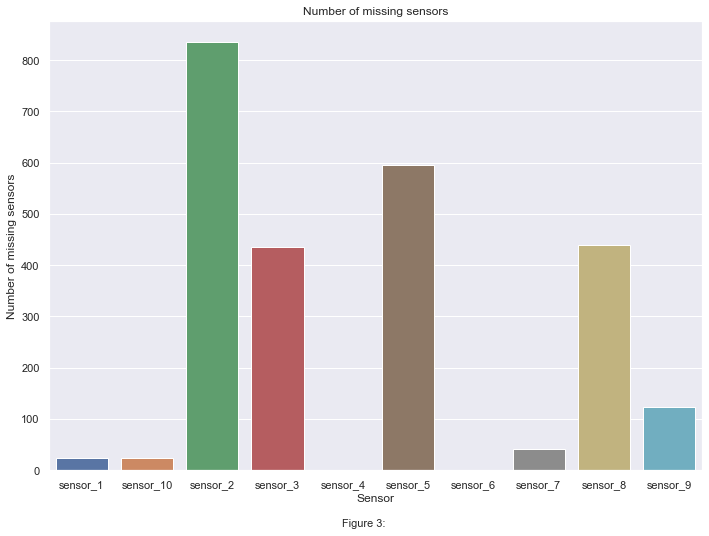

In [25]:
keys = list(missing_sensors.keys())
vals = [float(missing_sensors[k]) for k in keys]

a4_dims = (11.7, 8.27)

fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x=keys, y=vals, ax=ax)
plt.title("Number of missing sensors")
plt.xlabel("Sensor")
plt.ylabel("Number of missing sensors")
plt.figtext(0.5,0.03,'Figure {}: '.format(fig_nr), fontsize=11, horizontalalignment="center")

fig_nr = fig_nr + 1

In [26]:
df = clean_df(df)

df.head()

,sensor_1_kurtosis,sensor_10_kurtosis,sensor_2_kurtosis,sensor_3_kurtosis,sensor_4_kurtosis,sensor_5_kurtosis,sensor_6_kurtosis,sensor_7_kurtosis,sensor_8_kurtosis,sensor_9_kurtosis,...,sensor_10_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,time_to_eruption
segment_id,,,,,,,,,,,,,,,,,,,,,
1443158011,-0.500867,-0.756292,1.082533,-0.369448,0.537462,0.947902,-1.082187,20.971128,65.894733,0.360613,...,5443237.0,-9687742.0,-24616079.0,6573301.0,-4718989.0,-21918247.0,87729.0,-73423.0,14772926.0,13731766
179584121,0.612155,0.578505,2.294547,0.363843,1.083448,0.551613,0.100413,0.990655,1.874555,0.807765,...,-27591593.0,-6987940.0,-34675489.0,-19051459.0,-3466954.0,-40274251.0,-47237664.0,-33323029.0,-25148116.0,19387989
1848578834,0.099924,-0.514466,0.542925,0.183253,0.265696,0.350836,-0.984722,9.797522,11.821548,0.381292,...,-30138921.0,-14713477.0,4417294.0,-13398598.0,-1619204.0,-25743099.0,114191.0,-14172.0,-14328657.0,13982533
1925307864,-0.374988,-0.176205,-0.205315,-0.400745,-0.429961,-0.214006,-0.466535,-0.346940,-0.409043,-0.481846,...,-26132104.0,-8832804.0,-15820048.0,-27296327.0,-3840282.0,-25100803.0,-39263658.0,-58156438.0,-15136061.0,5538535
517946260,-0.147100,0.214609,0.041163,0.025550,0.000122,4.265570,0.236130,0.046331,0.029653,-0.233974,...,-4940102.0,3772988.0,4769316.0,-1375227.0,1233322.0,-1100525.0,73041.0,399783.0,3393940.0,3975965


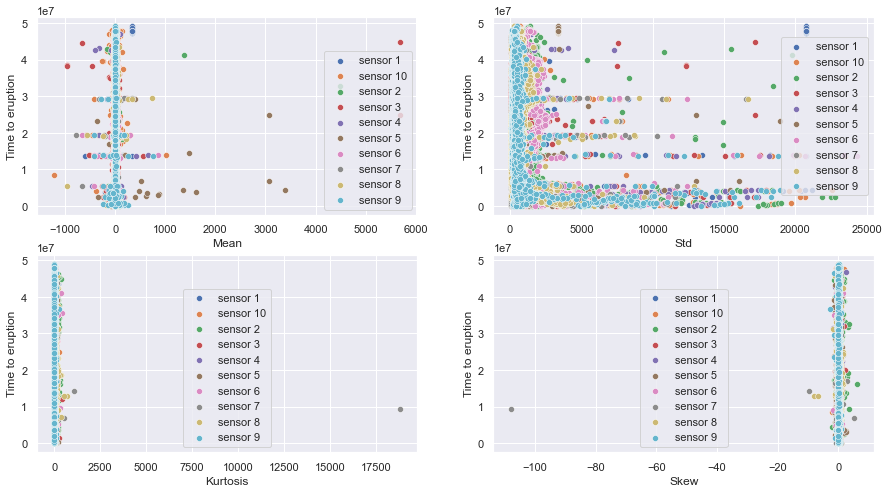

In [67]:
fig, axes = plt.subplots(2,2,figsize=(25,15))

metrics = ['mean', 'std', 'kurtosis', 'skew']

for i, ax in enumerate(axes.flatten()):
    for sensor_metric in list(df.filter(regex=metrics[i])):
        
        # Some lines for presenting the labels
        split = sensor_metric.split('_')
        sensor = split[0]+" "+split[1]
        
        sns.scatterplot(x=sensor_metric, y="time_to_eruption", data=df, ax=ax, label=sensor)
        
    ax.set_title("Sensor "+metrics[i]+" plotted against time to eruption")
    ax.set_xlabel(metrics[i].capitalize())
    ax.set_ylabel('Time to eruption')

plt.figtext(0.5,0.07,'Figure {}: '.format(fig_nr), fontsize=11, horizontalalignment="center")
plt.show()

fig_nr = fig_nr + 1

What is interesting to see, is that all of our values hover around the value 0. This can be explained by our use of seismic data, which means that any positive vibration eventually comes back as a negative vibration (just image the lines that a seismograph makes). Because we generated our train and test sets on these vibrations it is no surprise that our values hover around 0. If we really want to find any linear combinations, it should be essential for us to take the absolute values of our original dataset.

#### Model training

In [28]:
# X so that we remove time_to_eruption and sensor_id
X = df.drop(['time_to_eruption'], axis=1).values

# y so that we only have the time_to_eruption
y = df['time_to_eruption'].values

print(y)

[13731766 19387989 13982533 ... 47775708 47878878 47795821]


#### Linear regression

In [30]:
r2_sc, mae_score = linear_regression_generator(X, y)
    
print("Best R2 score: {}".format(r2_sc.mean()))
print("Best MAE: {}".format(mae_score.mean()))

Best R2 score: -9.132947025643535
Best MAE: 11582628.917454159


#### Random Forest

Tree depth: 100


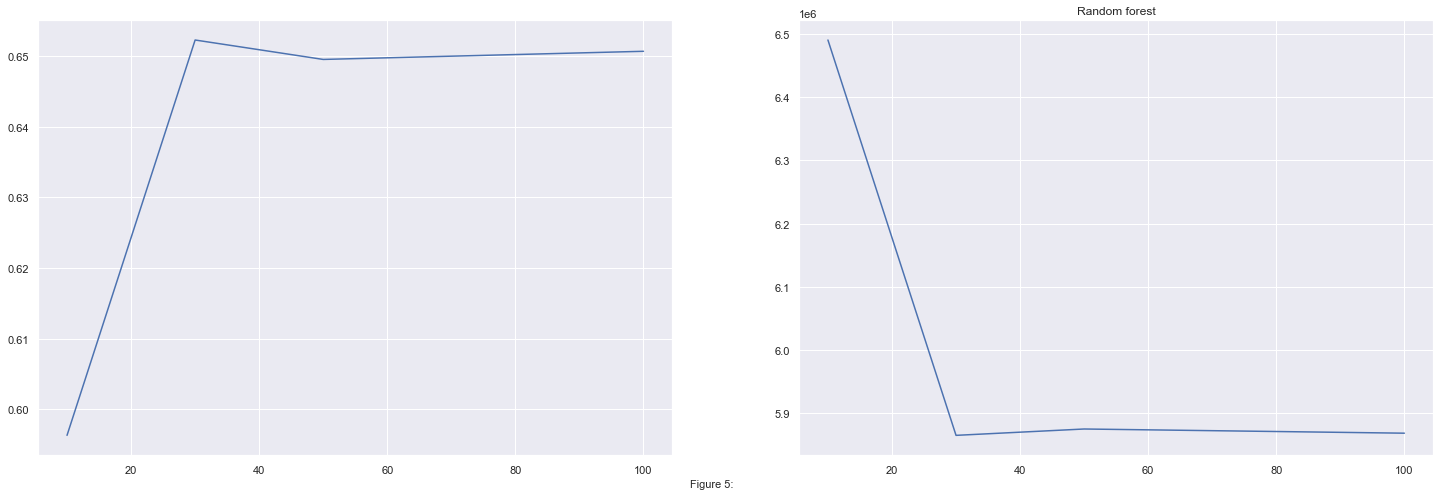

Best R2 score: 0.6522626882131443 with 30 max_depth 
Best MAE: 5854016.381200268 with None max_depth 


In [31]:
best_r2, best_mae = random_forest_generator(
    [None, 10, 30, 50, 100],
    X, 
    y, 
    'Figure {}: '.format(fig_nr), 
    "Random forest")
fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

#### K-Nearest Neighbor regressor

Neighbors trained: 40


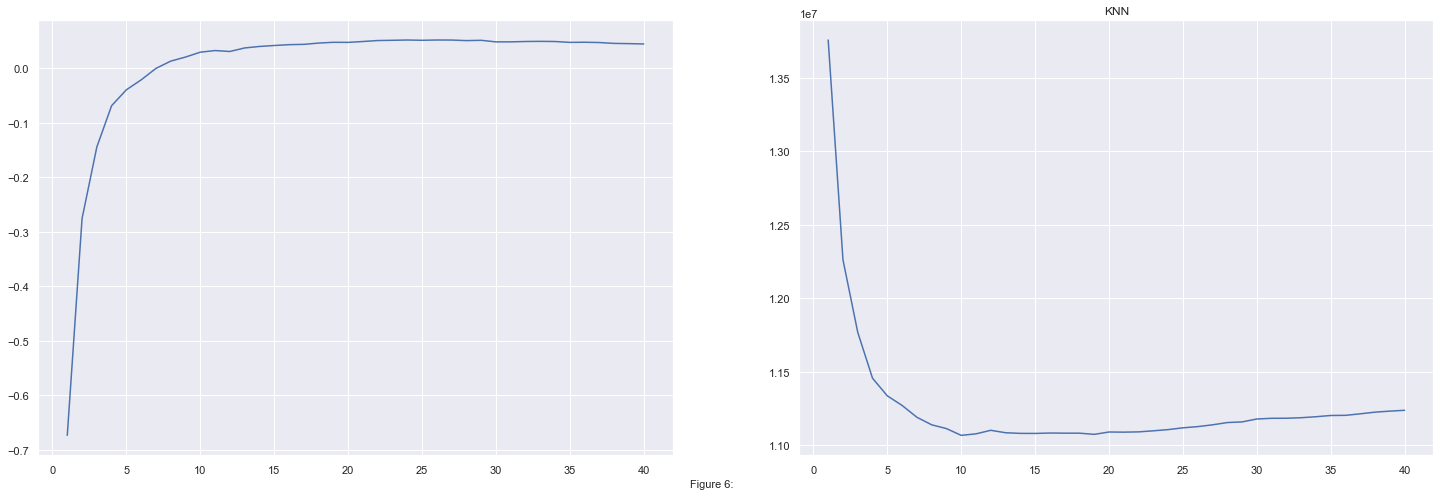

Best R2 score: 0.05230842004056787 with 26 max_depth 
Best MAE: 11066372.727955129 with 10 max_depth 


In [35]:
best_r2, best_mae = knn_generator(
    range(1,41),
    X, 
    y, 
    'Figure {}: '.format(fig_nr), 
    "KNN")

fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

### Trying absolute data

In [36]:
generate_abs_train_set = False
generate_abs_test_set = False

In [37]:
if(generate_abs_train_set): generate_aggregation("*", "data/train", "aggregated_abs_train", absolute=True, slice_amount=6)
    
if(generate_abs_test_set): generate_aggregation("*", "data/test", "aggregated_abs_test", absolute=True, slice_amount=6)

In [38]:
df_abs = pd.read_csv("aggregated_abs_train.csv")

In [39]:
df_abs = clean_df(df_abs)

df_abs.head()

,sensor_1_kurtosis,sensor_10_kurtosis,sensor_2_kurtosis,sensor_3_kurtosis,sensor_4_kurtosis,sensor_5_kurtosis,sensor_6_kurtosis,sensor_7_kurtosis,sensor_8_kurtosis,sensor_9_kurtosis,...,sensor_10_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,time_to_eruption
segment_id,,,,,,,,,,,,,,,,,,,,,
757144677,3.526094,8.940736,25.919718,2.520061,1.397474,49.799338,10.652386,3.148650,1.813752,2.630062,...,1405267.0,3345468.0,774729.0,1747194.0,637002.0,3871824.0,3138344.0,2364276.0,1179857.0,33318990
684012682,9.732040,11.343385,16.772796,3.739625,5.267583,58.701665,2.468255,1.030223,3.270216,4.748106,...,1488792.0,2111899.0,702688.0,805219.0,451180.0,1713362.0,1020445.0,1292443.0,820112.0,19770960
150692731,3.123129,7.152505,19.425024,4.543157,4.667316,42.722814,1.294553,1.663043,1.004756,8.054718,...,1372630.0,1994281.0,646025.0,787942.0,406657.0,1711440.0,1041929.0,1146433.0,792735.0,21438625
658099461,5.093539,18.528364,33.755994,3.506672,8.530541,30.182713,14.197751,20.784153,22.545142,9.875920,...,1557164.0,2947197.0,687986.0,860351.0,1178577.0,3512114.0,1202095.0,1991485.0,881290.0,31870009
1726437005,4.333028,6.338226,14.724671,4.428419,5.891275,25.811665,2.135182,2.435776,0.476493,4.817078,...,1391401.0,2058951.0,687401.0,757626.0,420941.0,2069531.0,1056078.0,1192538.0,774688.0,21379271


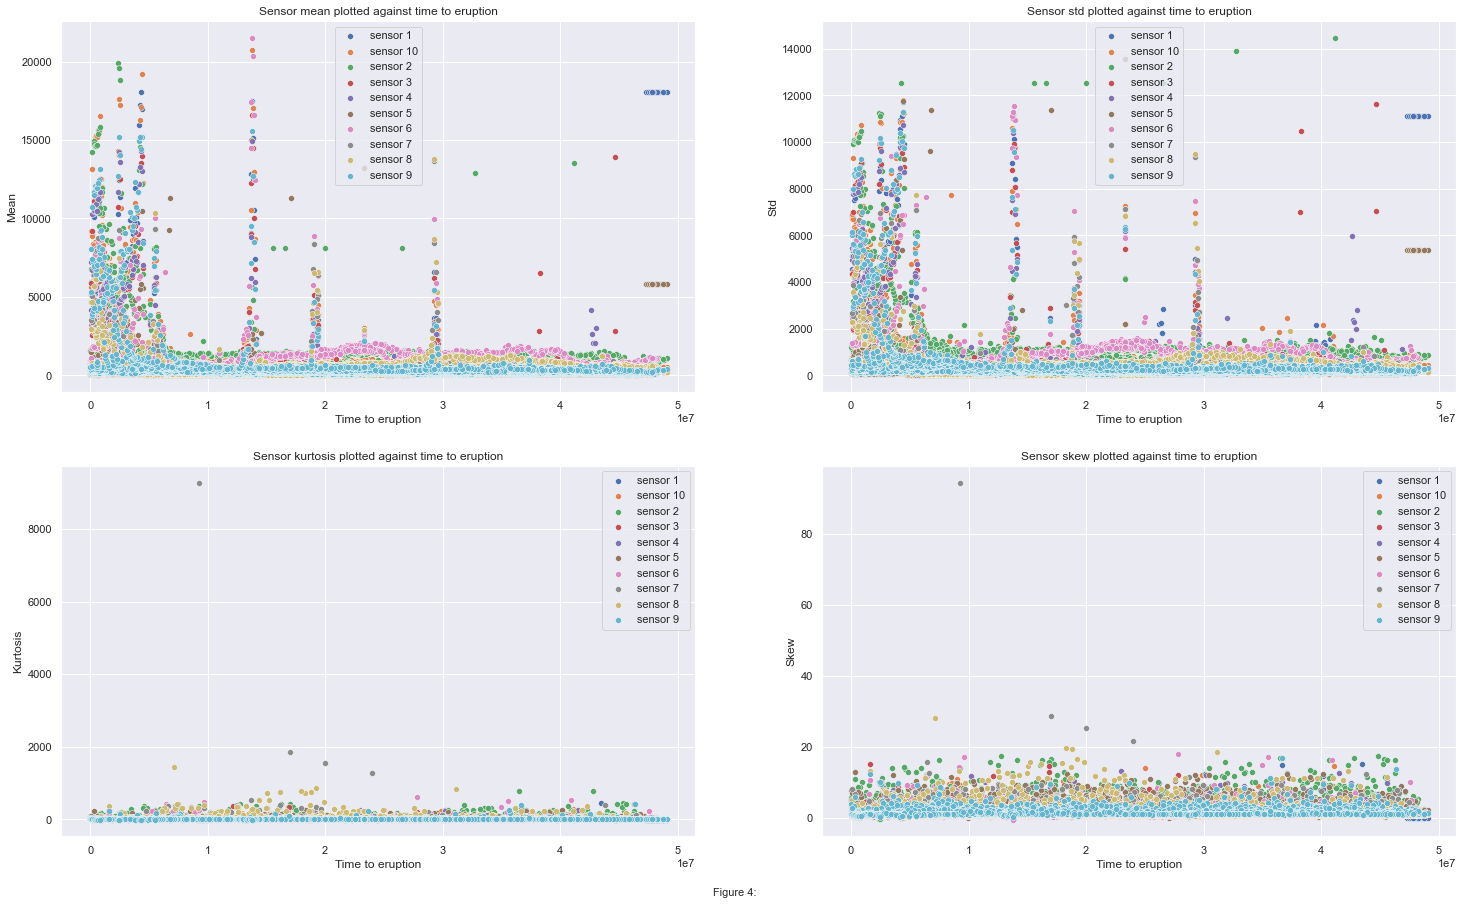

In [40]:
fig, axes = plt.subplots(2,2,figsize=(25,15))

metrics = ['mean', 'std', 'kurtosis', 'skew']

for i, ax in enumerate(axes.flatten()):
    for sensor_metric in list(df_abs.filter(regex=metrics[i])):
        
        # Some lines for presenting the labels
        split = sensor_metric.split('_')
        sensor = split[0]+" "+split[1]
        
        sns.scatterplot(x="time_to_eruption", y=sensor_metric, data=df_abs, ax=ax, label=sensor)
        
    ax.set_title("Sensor "+metrics[i]+" plotted against time to eruption")
    ax.set_ylabel(metrics[i].capitalize())
    ax.set_xlabel('Time to eruption')

plt.figtext(0.5,0.07,'Figure {}: '.format(fig_nr), fontsize=11, horizontalalignment="center")

plt.show()

fig_nr = fig_nr + 1

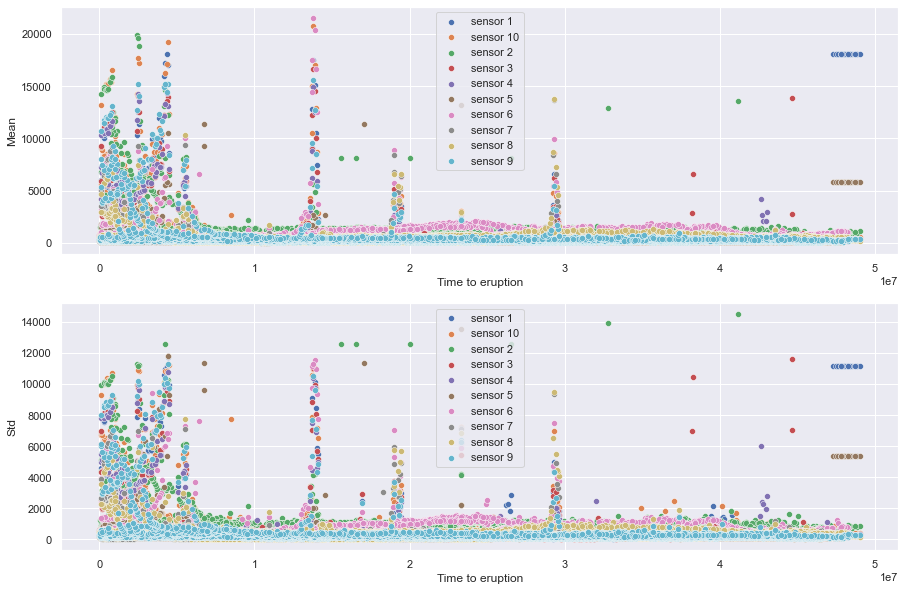

In [41]:
fig, axes = plt.subplots(2,1,figsize=(15,10))

metrics = ['mean', 'std']

for i, ax in enumerate(axes.flatten()):
    for sensor_metric in list(df_abs.filter(regex=metrics[i])):
        
        # Some lines for presenting the labels
        split = sensor_metric.split('_')
        sensor = split[0]+" "+split[1]
        
        sns.scatterplot(x="time_to_eruption", y=sensor_metric, data=df_abs, ax=ax, label=sensor)
        
    ax.set_ylabel(metrics[i].capitalize())
    ax.set_xlabel('Time to eruption')

plt.savefig("linear", bbox_inches = 'tight', pad_inches = 0)

plt.show()

In [42]:
# X so that we remove time_to_eruption and sensor_id
X_abs = df_abs.drop(['time_to_eruption'], axis=1).values

# y so that we only have the time_to_eruption
y_abs = df_abs['time_to_eruption'].values

X_abs.shape

(4431, 110)

In [43]:
r2_sc, mae_score = linear_regression_generator(X_abs, y_abs)
    
print("Best R2 score: {}".format(r2_sc.mean()))
print("Best MAE: {}".format(mae_score.mean()))

Best R2 score: -7.701383601661391
Best MAE: 11467076.863423478


Tree depth: 100


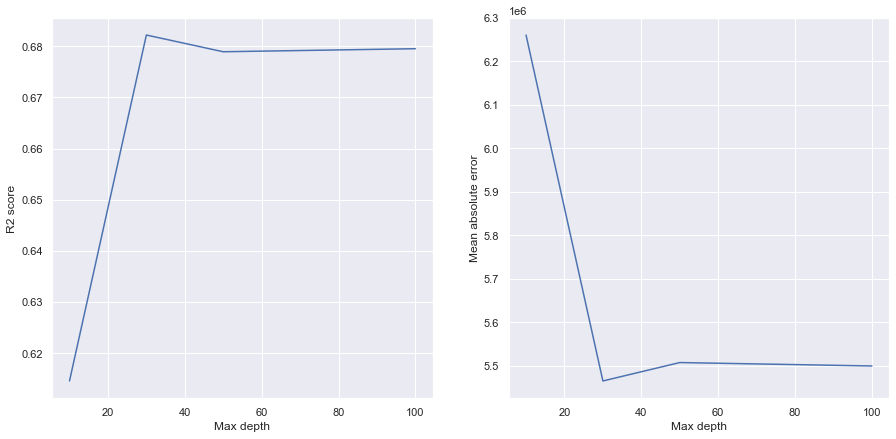

Best R2 score: 0.6821877342824434 with 30 max_depth 
Best MAE: 5465361.499779258 with 30 max_depth 


In [48]:
best_r2, best_mae = random_forest_generator(
    [None, 10, 30, 50, 100], 
    X_abs, 
    y_abs, 
    "", 
    "")

fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

Neighbors trained: 40


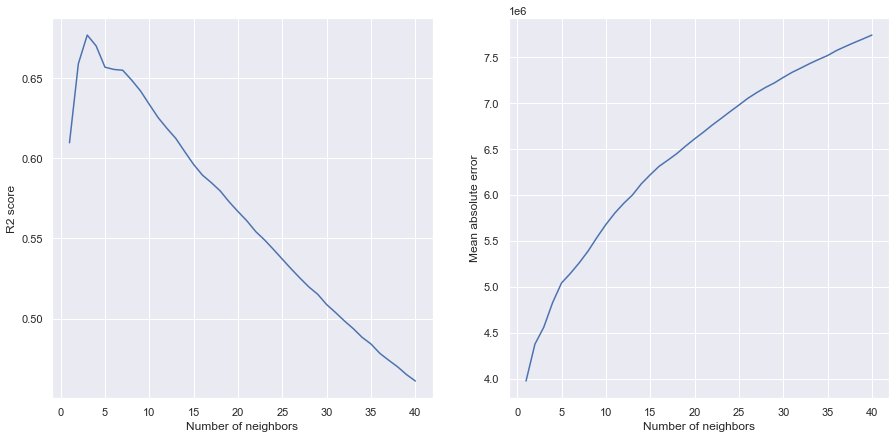

Best R2 score: 0.6768638972680027 with 3 max_depth 
Best MAE: 3973215.4259202196 with 1 max_depth 


In [63]:
best_r2, best_mae = knn_generator(
    range(1,41),
    X_abs, 
    y_abs, 
    "", 
    "")

fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

### Including Principal Component Analysis

In [44]:
generate_abs_pca_train_set = False
generate_abs_pca_test_set = False

In [45]:
if(generate_abs_pca_train_set): generate_aggregation("*", "data/train", "aggregated_abs_pca_train", absolute=True, slice_amount=6, principal_components=4)
    
if(generate_abs_pca_test_set): generate_aggregation("*", "data/test", "aggregated_abs_pca_test", absolute=True, slice_amount=6, principal_components=4)

In [46]:
df_pca = pd.read_csv("aggregated_abs_pca_train.csv")

df_pca = clean_df(df_pca)

df_pca.head()

,pc1_kurtosis,pc2_kurtosis,pc3_kurtosis,pc4_kurtosis,sensor_1_kurtosis,sensor_10_kurtosis,sensor_2_kurtosis,sensor_3_kurtosis,sensor_4_kurtosis,sensor_5_kurtosis,...,sensor_10_sum,sensor_2_sum,sensor_3_sum,sensor_4_sum,sensor_5_sum,sensor_6_sum,sensor_7_sum,sensor_8_sum,sensor_9_sum,time_to_eruption
segment_id,,,,,,,,,,,,,,,,,,,,,
757144677,9.036387,5.676238,1.200403,1.461557,3.526094,8.940736,25.919718,2.520061,1.397474,49.799338,...,1405267.0,3345468.0,774729.0,1747194.0,637002.0,3871824.0,3138344.0,2364276.0,1179857.0,33318990
684012682,6.660360,3.669002,1.311476,0.691574,9.732040,11.343385,16.772796,3.739625,5.267583,58.701665,...,1488792.0,2111899.0,702688.0,805219.0,451180.0,1713362.0,1020445.0,1292443.0,820112.0,19770960
150692731,4.817638,4.229741,0.556770,0.343009,3.123129,7.152505,19.425024,4.543157,4.667316,42.722814,...,1372630.0,1994281.0,646025.0,787942.0,406657.0,1711440.0,1041929.0,1146433.0,792735.0,21438625
658099461,9.843701,13.697599,8.392832,8.294375,5.093539,18.528364,33.755994,3.506672,8.530541,30.182713,...,1557164.0,2947197.0,687986.0,860351.0,1178577.0,3512114.0,1202095.0,1991485.0,881290.0,31870009
1726437005,3.238031,3.811596,0.599376,0.449980,4.333028,6.338226,14.724671,4.428419,5.891275,25.811665,...,1391401.0,2058951.0,687401.0,757626.0,420941.0,2069531.0,1056078.0,1192538.0,774688.0,21379271


In [47]:
X_pca = df_pca.drop(['time_to_eruption'], axis=1).values

y_pca = df_pca['time_to_eruption'].values

X_pca.shape

(4431, 150)

Tree depth: 100


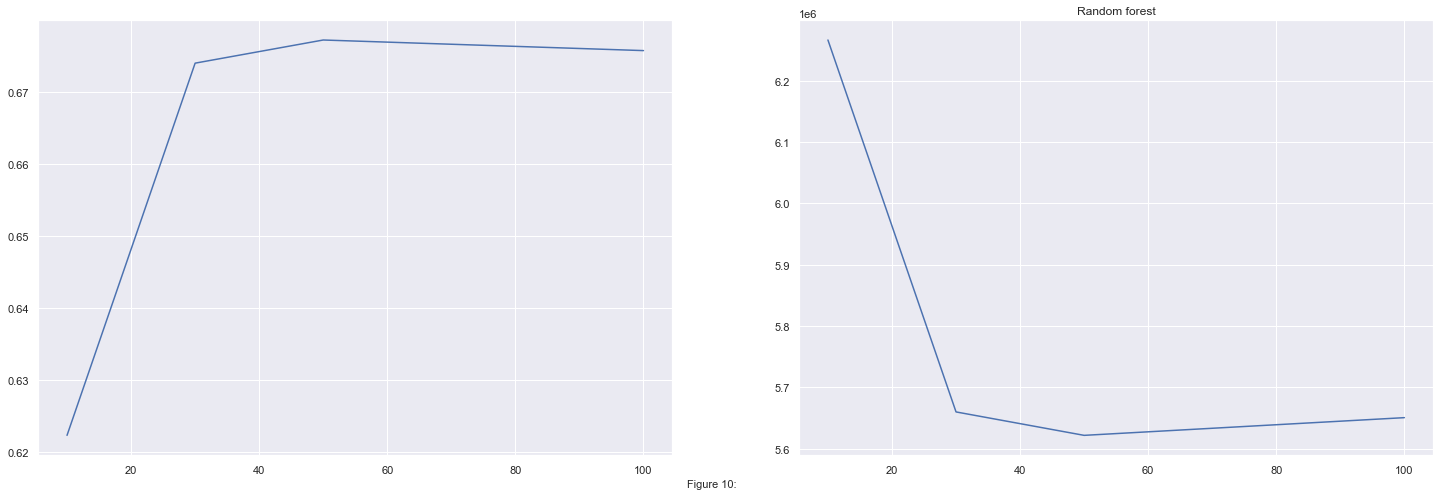

Best R2 score: 0.6772147003993704 with 50 max_depth 
Best MAE: 5621698.768724432 with 50 max_depth 


In [49]:
best_r2, best_mae = random_forest_generator(
    [None, 10, 30, 50, 100],
    X_pca, 
    y_pca, 
    'Figure {}: '.format(fig_nr), 
    "Random forest")
fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

Neighbors trained: 40


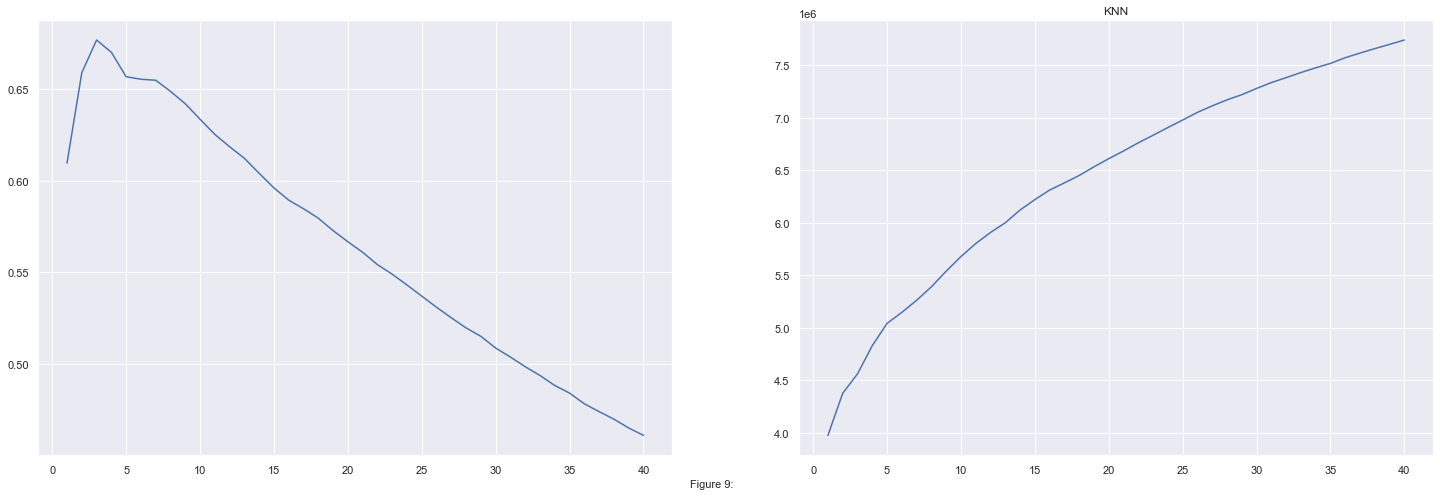

Best R2 score: 0.6768638972680027 with 3 max_depth 
Best MAE: 3973215.4259202196 with 1 max_depth 


In [48]:
best_r2, best_mae = knn_generator(
    range(1,41),
    X_pca, 
    y_pca, 
    'Figure {}: '.format(fig_nr), 
    "KNN")

fig_nr = fig_nr + 1

print("Best R2 score: {} with {} max_depth ".format(best_r2['val'], best_r2['var']))
print("Best MAE: {} with {} max_depth ".format(best_mae['val'], best_mae['var']))

### Optimizing best model and metric using GridSearch

In [ ]:
grid_params = { 
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan'],
    'n_neighbors': [1, 2, 3, 5, 8, 13, 21, 34]
}

clf = GridSearchCV(KNeighborsRegressor(), grid_params, verbose=1, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error')
    
clf_results = clf.fit(X_abs, y_abs)

print(clf_results.best_estimator_)

In [ ]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
    
model = clf_results.best_estimator_
   
r2_sc = np.array([])
mae_score = np.array([])
    
for train_index, test_index in kf.split(X_abs):        
    X_train, X_test = X_abs[train_index], X_abs[test_index]
    y_train, y_test = y_abs[train_index], y_abs[test_index]

    model = model.fit(X_train, y_train)

    pred = model.predict(X_test)

    r2_sc = np.append(r2_sc, r2_score(y_test, pred))
    mae_score = np.append(mae_score, mean_absolute_error(y_test, pred))
    
print(r2_sc.mean())
print(mae_score.mean())

### Train on all the data
We have seen that KNN performs best on absolute valued data with K=2 neighbors. Let's test on all the data

In [ ]:
train_all = pd.read_csv("aggregated_abs_train.csv")
submission_files = pd.read_csv("aggregated_abs_test.csv")
    
train_all = clean_df(train_all)
submission_files = clean_df(submission_files)

train_all.head()

In [ ]:
X_final = train_all.drop(['time_to_eruption'], axis=1).values
y_final = train_all['time_to_eruption'].values

X_submission = submission_files.drop(['time_to_eruption'], axis=1).values
segment_ids = submission_files.index

In [ ]:
model = clf_results.best_estimator_
model.fit(X_final, y_final)

preds = model.predict(X_submission)

#### Generating submission set

In [ ]:
values = {'segment_id':segment_ids,'time_to_eruption':preds}

df_submission = pd.DataFrame(values)
df_submission.head()

In [ ]:
df_submission.shape

In [ ]:
if df_submission.shape[0] == 4520:
    df_submission.to_csv('submission.csv', index=False)  